# Notes

Space for running small experiments on the code to check whether and how things work.

# 1. Test Environment Function
**Objective:** Test the get_closest_food function visually. 

closest_position: [38.10078035  8.64841474]
closest_distance: 1.0115518817550206


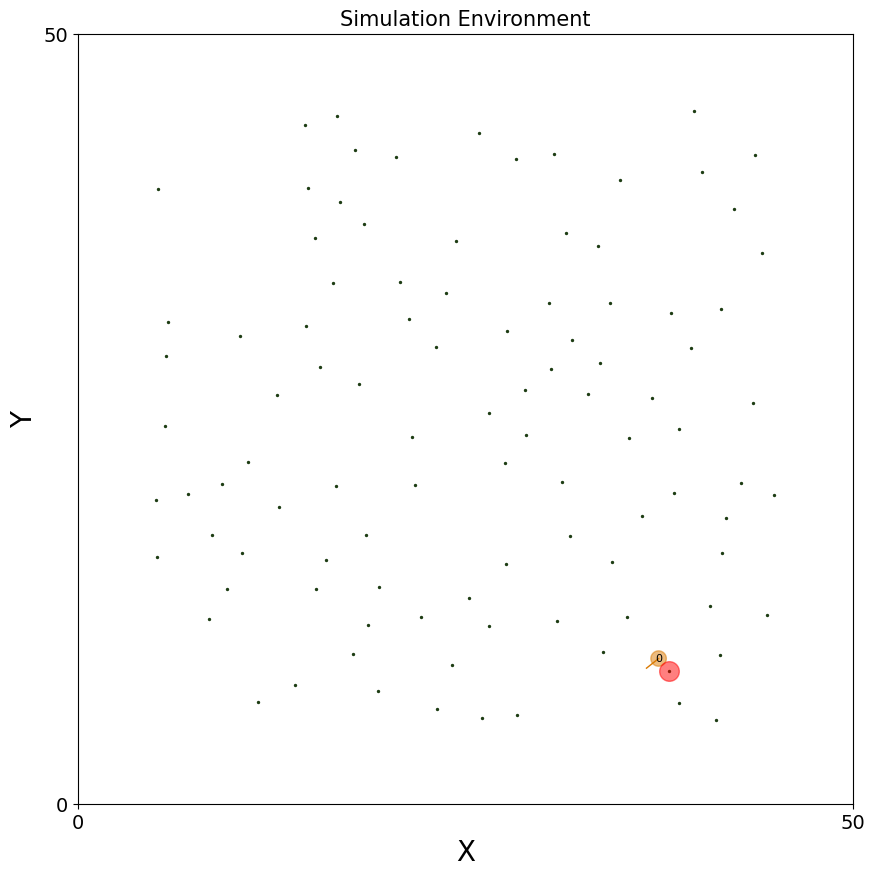

In [15]:
from environment import Environment
from parameters import Params
from visualization import visualize_state
import matplotlib.pyplot as plt
from agent import BallisticAgent
import numpy as np

TEST_PERIODIC_BOUNDARIES = False

params = Params.from_json('parameters.json')
params.num_food = 100
params.size = 50
environment = Environment(params)
agent = BallisticAgent(params)

# extra test for periodic boundaries
if TEST_PERIODIC_BOUNDARIES:
    agent.position = np.array([environment.size - 10, environment.size/2])
    agent.food_mask = np.zeros(2, dtype=bool)
    environment.food_positions = np.asarray([[environment.size/3, environment.size/2], [10, environment.size/2]])
    environment.num_food = 2

ax = visualize_state(environment, [agent])

agent.perception_radius = environment.size
closest_position, closest_distance, closest_index = environment.get_closest_food(agent)
print('closest_position:', closest_position)
print('closest_distance:', closest_distance)

ax.scatter(closest_position[0], closest_position[1], color='red', s=200, alpha=0.5)
plt.show()

# 2. Test Agent Food Consumption

**Objective**: Test whether agents take up all food particles on their path even if they did not directly land on it.

Animating 1/1:  40%|████      | 2/5 [00:00<00:00, 19.36frame/s]

Safed animation under:
/home/lewin/levy-agent-simulation/data/experiments
2.0


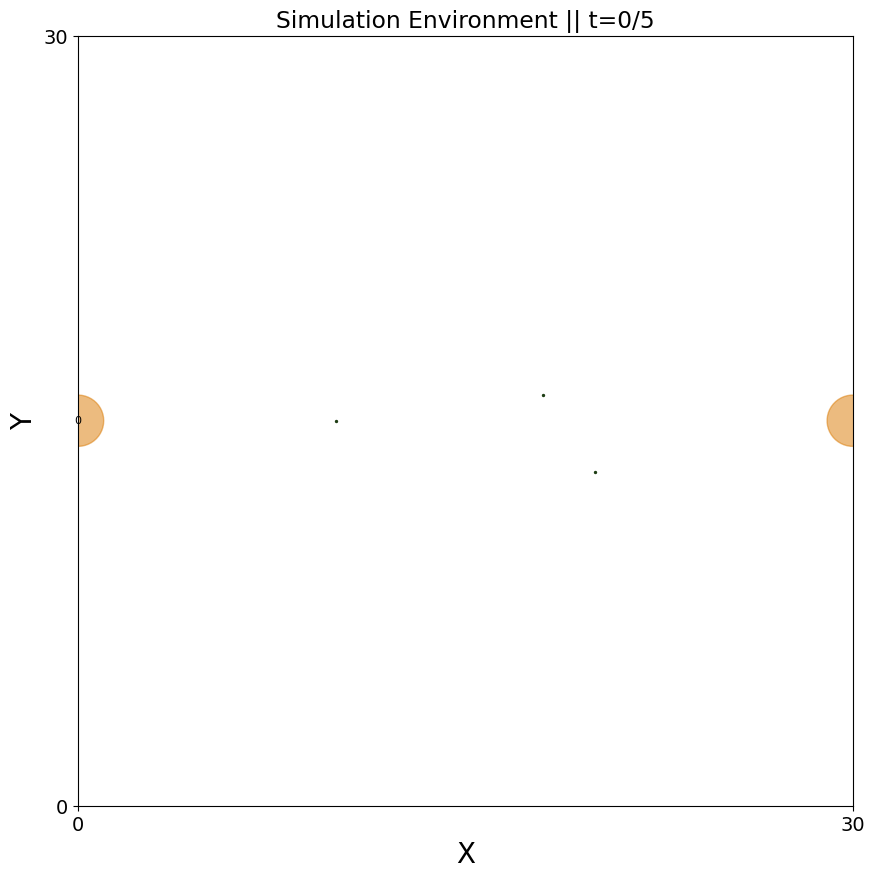

Animating 1/1:  40%|████      | 2/5 [00:18<00:00, 19.36frame/s]

In [ ]:
from agent import BallisticAgent
from environment import Environment
from parameters import Params
from simulation import Simulation
from data_io import initialize_data
from visualization import animate_single_iteration
import numpy as np

SIZE = 30
EAT_RADIUS = 1
FOOD_POSITIONS = np.array([[SIZE/3, SIZE/2], 
                           [3*SIZE/5, SIZE/2+EAT_RADIUS], 
                           [2*SIZE/3, SIZE/2-2*EAT_RADIUS]])
NUM_FOOD = len(FOOD_POSITIONS)
VELOCITY = 1
NUM_ITERATIONS = 1
POPULATION_SIZE = 1
DELTA_T = SIZE/2
TOTAL_TIME = 4*DELTA_T

folder = 'experiments'

params = Params(
    num_food = NUM_FOOD,
    size = SIZE,
    velocity = VELOCITY,
    eat_radius = EAT_RADIUS,
    iterations = NUM_ITERATIONS,
    population_size = POPULATION_SIZE,
    total_time = TOTAL_TIME,
    delta_t = DELTA_T,
    border_buffer = 2,
    food_buffer = 2,
    perception_radius = EAT_RADIUS,
    seed = 10,
    resetting_boundary = False
)

environment = Environment(params)
environment.food_positions = FOOD_POSITIONS
environment.num_food = NUM_FOOD

data = initialize_data(params)
agent = BallisticAgent(params)
agent.direction = 0
agent.position = np.array([0, params.size/2])
population = [agent]

sim = Simulation(params, BallisticAgent)
population[0].reset = lambda: None
sim.run_iteration(population, environment)
animate_single_iteration(0, environment, params, sim.data, 'experiments', 0, save=True)
print(sim.data['ate'].values.sum())

The check_path function is not periodic boundary safe, this is why the agent does not detect the second food particle.
Decreasing DELTA_T to SIZE/3 makes the agent detect the food particle.